In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf

C:\Users\cadet\AppData\Local\Temp\ipykernel_18380\4272495862.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('./steam.csv')

In [3]:
df['user_review'] = df['user_review'].apply(lambda x : str(x).strip())
df = df.dropna()

In [4]:
df['user_review'].apply(lambda x: str(x).strip() == '').sum()

0

#### Detect language to remove non english data

In [5]:
from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return 'unknown'

ModuleNotFoundError: No module named 'langdetect'

In [ ]:
df['lang'] = df['user_review'].apply(detect_lang)
df['lang'].unique()

array(['en', 'so', 'unknown', 'vi', 'no', 'it', 'sk', 'uk', 'pl', 'de',
       'nl', 'cy', 'tl', 'hu', 'el', 'ru', 'tr', 'et', 'ja', 'bg', 'es',
       'fr', 'cs', 'pt', 'sw', 'da', 'ro', 'ko', 'zh-cn', 'sv', 'th',
       'fi', 'he', 'sl', 'id'], dtype=object)

In [ ]:
df = df[df['lang'] == 'en'] # Keep only english reviews

df = df[:1000] # Subsample

In [ ]:
def clean_data(text):
    # Remove all the special characters
    processed_text = re.sub(r'\W', ' ', text)
    # remove all single characters
    processed_text= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_text)
    # Remove single characters from the start
    processed_text = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_text)
    # Substituting multiple spaces with single space
    processed_text = re.sub(r'\s+', ' ', processed_text, flags=re.I)
    # Removing prefixed 'b'
    processed_text = re.sub(r'^b\s+', '', processed_text)
    # Converting to Lowercase
    processed_text = processed_text.lower()

    return processed_text

In [ ]:
df['user_review'] = df['user_review'].apply(clean_data)
df

,review_id,title,year,user_review,user_suggestion,lang
0,1,Spooky's Jump Scare Mansion,2016.0,i scared and hearing creepy voices so ll pause...,1,en
1,2,Spooky's Jump Scare Mansion,2016.0,best game more better than sam pepper youtube ...,1,en
2,3,Spooky's Jump Scare Mansion,2016.0,a littly iffy on the controls but once you kno...,1,en
3,4,Spooky's Jump Scare Mansion,2015.0,great game fun and colorful and all that side ...,1,en
4,5,Spooky's Jump Scare Mansion,2015.0,not many games have the cute tag right next to...,1,en
...,...,...,...,...,...,...
1021,1022,Fractured Space,2016.0,early access reviewhoo rah this game deserves ...,1,en
1022,1023,Fractured Space,2016.0,i like this game lot because ve been big fans ...,1,en
1023,1024,Fractured Space,2016.0,world of tanks in space meets moba being f2p w...,1,en
1024,1025,Fractured Space,2016.0,early access reviewlots of strategy and tactic...,1,en


In [ ]:
df = df[['user_review', 'user_suggestion']]
df

,user_review,user_suggestion
0,i scared and hearing creepy voices so ll pause...,1
1,best game more better than sam pepper youtube ...,1
2,a littly iffy on the controls but once you kno...,1
3,great game fun and colorful and all that side ...,1
4,not many games have the cute tag right next to...,1
...,...,...
1021,early access reviewhoo rah this game deserves ...,1
1022,i like this game lot because ve been big fans ...,1
1023,world of tanks in space meets moba being f2p w...,1
1024,early access reviewlots of strategy and tactic...,1


In [ ]:
df = df.drop_duplicates(subset="user_review")
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 1025
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   user_review      1000 non-null   object
 1   user_suggestion  1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 23.4+ KB


[]

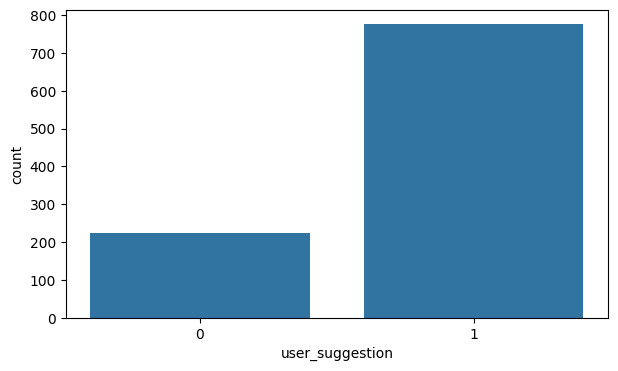

In [ ]:
plt.figure(figsize=[7, 4])
sns.countplot(x= df["user_suggestion"], data=df)
plt.plot()

In [ ]:

diff = len(df) - len(df[df['user_suggestion'] == 1])
weight_ratio = len(df) / diff


In [ ]:
from tensorflow.keras.layers import TextVectorization

max_length = 100
vocabs = 10000 # To be adjusted with the number of word actually present within the dataset and their frequency

In [ ]:
vectorize_layer = TextVectorization(
    # standardize=custom_standardization, # To be used instead of pre processing the text before
    max_tokens=vocabs,
    output_mode='int',
    output_sequence_length=max_length)


In [ ]:
from sklearn.model_selection import train_test_split
y = df["user_suggestion"]
x = df['user_review']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=32)

In [ ]:
vectorize_layer.adapt(x_train.values)

In [ ]:
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Embedding, Flatten, LSTM, Dropout, GRU, GlobalAveragePooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
vectorizer = Sequential([
    tf.keras.Input(shape=(1,), dtype=tf.string), # Input
    vectorize_layer, # Output
    Embedding(input_dim = vocabs, output_dim = 100, input_length=max_length)
])
input_data = [["i scared and hearing creepy voices"], ["it more like world of tanks in space but with"]]
vectorizer.predict(input_data)

1/1 [==============================] - 0s 54ms/step


array([[[-0.01145682,  0.01360292, -0.01853815, ..., -0.02410907,
         -0.03743096, -0.00668894],
        [ 0.04308221, -0.03169602, -0.01313264, ..., -0.03239029,
         -0.04024638,  0.04295117],
        [ 0.00659401,  0.00524842, -0.04986289, ...,  0.04617048,
          0.03260129, -0.00952022],
        ...,
        [ 0.01172156, -0.04474051, -0.04512117, ..., -0.01857225,
          0.01873845,  0.03943801],
        [ 0.01172156, -0.04474051, -0.04512117, ..., -0.01857225,
          0.01873845,  0.03943801],
        [ 0.01172156, -0.04474051, -0.04512117, ..., -0.01857225,
          0.01873845,  0.03943801]],

       [[ 0.04805137, -0.00630801, -0.0358571 , ..., -0.01885675,
          0.00610886,  0.00573869],
        [ 0.00495787, -0.03389368,  0.02602977, ..., -0.01944344,
         -0.01832708,  0.04218844],
        [ 0.04517173, -0.0447663 , -0.03312756, ...,  0.01755409,
          0.00278723, -0.00176303],
        ...,
        [ 0.01172156, -0.04474051, -0.04512117, ..., -

In [ ]:
model = Sequential([
    vectorize_layer,
    Embedding(input_dim = vocabs, output_dim = 100, input_length=max_length),
    # LSTM(128, recurrent_activation="sigmoid"),
    GlobalAveragePooling1D(),
    Dense(128, activation="relu"), # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    # Dropout(0.2), # Randomly set inputs to 0 with the probability in input, here 0.2 to prevent overfitting
    Dense(1, activation = "sigmoid"), # Output function
])

In [ ]:
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (Text  (None, 100)               0         
 Vectorization)                                                  
                                                                 
 embedding_33 (Embedding)    (None, 100, 100)          1000000   
                                                                 
 global_average_pooling1d_8  (None, 100)               0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense_52 (Dense)            (None, 128)               12928     
                                                                 
 dense_53 (Dense)            (None, 1)                 129       
                                                                 
Total params: 1013057 (3.86 MB)
Trainable params: 101

In [ ]:
callback = EarlyStopping(patience=2, monitor='val_loss') # patience = number of epochs without improvment of the val_loss
# Create a callback that saves the model's weights
#cp_callback = ModelCheckpoint(filepath='save_path.keras'),
#                                                 save_weights_only=True,
#                                                 verbose=1)

model.compile(optimizer=Adam(learning_rate=0.001), # Optimizer modifies the weights with specified learning rate
              loss=BinaryCrossentropy(),
              metrics=["accuracy"],
              )

model.fit(x_train, y_train,
          epochs=20,
          validation_data=(x_test, y_test),
          batch_size=32,
          callbacks = callback
          )

Epoch 1/20
25/25 [==============================] - 1s 11ms/step - loss: 0.6288 - accuracy: 0.7738 - val_loss: 0.5542 - val_accuracy: 0.7800
Epoch 2/20
25/25 [==============================] - 0s 7ms/step - loss: 0.5334 - accuracy: 0.7750 - val_loss: 0.5229 - val_accuracy: 0.7800
Epoch 3/20
25/25 [==============================] - 0s 7ms/step - loss: 0.5013 - accuracy: 0.7750 - val_loss: 0.5083 - val_accuracy: 0.7800
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4664 - accuracy: 0.7750 - val_loss: 0.4894 - val_accuracy: 0.7800
Epoch 5/20
25/25 [==============================] - 0s 6ms/step - loss: 0.4058 - accuracy: 0.7788 - val_loss: 0.4581 - val_accuracy: 0.7800
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.3170 - accuracy: 0.8275 - val_loss: 0.4195 - val_accuracy: 0.8250
Epoch 7/20
25/25 [==============================] - 0s 7ms/step - loss: 0.2217 - accuracy: 0.9237 - val_loss: 0.3941 - val_accuracy: 0.8400
Epoch 8/20
25/25 [=

In [ ]:
model.evaluate(x_test, y_test) # Returns loss and accuracy

7/7 [==============================] - 0s 2ms/step - loss: 0.4418 - accuracy: 0.8350


[0.44183310866355896, 0.8349999785423279]

In [ ]:
y_test_predict = model.predict(x_test.values)
y_test_predict = np.round(y_test_predict)

7/7 [==============================] - 0s 2ms/step


In [ ]:
tf.math.confusion_matrix(
    y_test,
    y_test_predict,
    num_classes=None,
    weights=None,
    dtype=tf.dtypes.int32,
    name=None
)


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[ 15,  29],
       [  4, 152]], dtype=int32)>

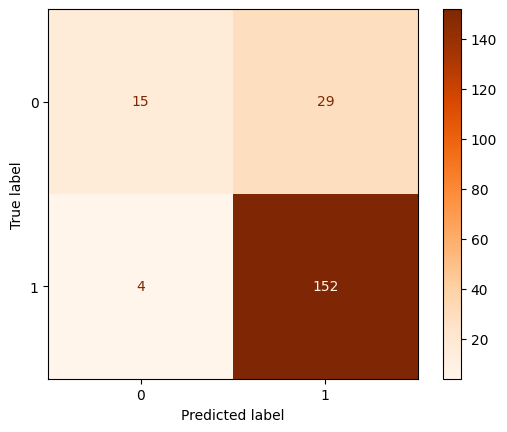

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict, cmap="Oranges")
plt.show()

In [ ]:
model.predict([ 'i scared and hearing creepy voices ' ])

1/1 [==============================] - 0s 23ms/step


array([[0.95997506]], dtype=float32)

In [ ]:
model.save('my_model.keras')
from tensorflow.keras.models import load_model
new_model = load_model('my_model.keras')
model.predict(['this game is really good, I like it', 'game is not good' ])

1/1 [==============================] - 0s 20ms/step


array([[0.9232207 ],
       [0.89154506]], dtype=float32)

### d

In [ ]:

gru_model = Sequential([
    vectorize_layer,
    Embedding(input_dim = vocabs, output_dim = 100, input_length=max_length),
    GRU(64),
    Dense(64, activation="relu"), # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    Dropout(0.2),
    Dense(1, activation = "sigmoid"), # Output function
])

gru_model.compile(optimizer=Adam(learning_rate=0.001), # Optimizer modifies the weights with specified learning rate
              loss=BinaryCrossentropy(),
              metrics=["accuracy"],
              )

gru_model.fit(x_train, y_train,
          epochs=25,
          validation_data=(x_test, y_test),
          batch_size=32,
          )

Epoch 1/25
25/25 [==============================] - 2s 34ms/step - loss: 0.6038 - accuracy: 0.7725 - val_loss: 0.5417 - val_accuracy: 0.7800
Epoch 2/25
25/25 [==============================] - 1s 27ms/step - loss: 0.5451 - accuracy: 0.7750 - val_loss: 0.5290 - val_accuracy: 0.7800
Epoch 3/25
25/25 [==============================] - 1s 26ms/step - loss: 0.5240 - accuracy: 0.7750 - val_loss: 0.5294 - val_accuracy: 0.7800
Epoch 4/25
25/25 [==============================] - 1s 26ms/step - loss: 0.4985 - accuracy: 0.7750 - val_loss: 0.5330 - val_accuracy: 0.7800
Epoch 5/25
25/25 [==============================] - 1s 26ms/step - loss: 0.4454 - accuracy: 0.8000 - val_loss: 0.5902 - val_accuracy: 0.7600
Epoch 6/25
25/25 [==============================] - 1s 26ms/step - loss: 0.4050 - accuracy: 0.8450 - val_loss: 0.5882 - val_accuracy: 0.7500
Epoch 7/25
25/25 [==============================] - 1s 26ms/step - loss: 0.3878 - accuracy: 0.8487 - val_loss: 0.6278 - val_accuracy: 0.7650
Epoch 8/25
25

In [ ]:
gru_model.evaluate(x_test, y_test) # Returns loss and accuracy

7/7 [==============================] - 0s 8ms/step - loss: 1.8210 - accuracy: 0.7300


[1.8209675550460815, 0.7300000190734863]

In [ ]:
y_test_predict = gru_model.predict(x_test.values)
y_test_predict = np.round(y_test_predict)

7/7 [==============================] - 0s 8ms/step


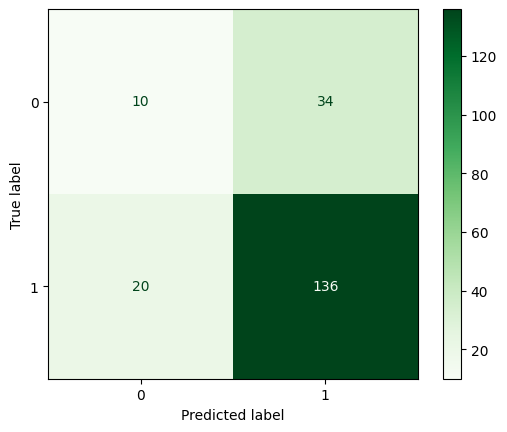

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict, cmap="Greens")
plt.show()

In [ ]:
gru_nodropout_model = Sequential([
    vectorize_layer,
    Embedding(input_dim = vocabs, output_dim = 100, input_length=max_length),
    GRU(64),
    Dense(64, activation="relu"), # https://en.wikipedia.org/wiki/Rectifier_(neural_networks)
    Dense(1, activation = "sigmoid"), # Output function
])

gru_nodropout_model.compile(optimizer=Adam(learning_rate=0.001), # Optimizer modifies the weights with specified learning rate
              loss=BinaryCrossentropy(),
              metrics=["accuracy"],
              )

gru_nodropout_model.fit(x_train, y_train,
          epochs=25,
          validation_data=(x_test, y_test),
          batch_size=32,
          )

Epoch 1/25
25/25 [==============================] - 2s 37ms/step - loss: 0.5990 - accuracy: 0.7613 - val_loss: 0.5352 - val_accuracy: 0.7800
Epoch 2/25
25/25 [==============================] - 1s 32ms/step - loss: 0.5353 - accuracy: 0.7750 - val_loss: 0.5279 - val_accuracy: 0.7800
Epoch 3/25
25/25 [==============================] - 1s 27ms/step - loss: 0.5177 - accuracy: 0.7750 - val_loss: 0.5273 - val_accuracy: 0.7800
Epoch 4/25
25/25 [==============================] - 1s 28ms/step - loss: 0.4916 - accuracy: 0.7750 - val_loss: 0.5481 - val_accuracy: 0.7800
Epoch 5/25
25/25 [==============================] - 1s 27ms/step - loss: 0.4511 - accuracy: 0.8112 - val_loss: 0.5761 - val_accuracy: 0.7750
Epoch 6/25
25/25 [==============================] - 1s 27ms/step - loss: 0.3960 - accuracy: 0.8438 - val_loss: 0.6054 - val_accuracy: 0.7550
Epoch 7/25
25/25 [==============================] - 1s 31ms/step - loss: 0.3771 - accuracy: 0.8475 - val_loss: 0.6020 - val_accuracy: 0.7600
Epoch 8/25
25

In [ ]:
gru_nodropout_model.evaluate(x_test, y_test) # Returns loss and accuracy

7/7 [==============================] - 0s 9ms/step - loss: 1.6553 - accuracy: 0.7550


[1.6552625894546509, 0.7549999952316284]

In [ ]:
y_test_predict = gru_model.predict(x_test.values)
y_test_predict = np.round(y_test_predict)

7/7 [==============================] - 0s 9ms/step


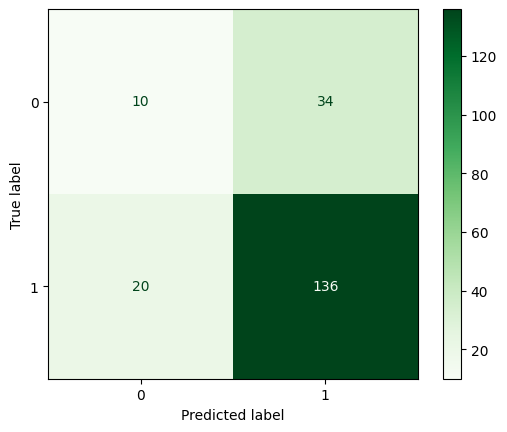

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
ConfusionMatrixDisplay.from_predictions(y_test, y_test_predict, cmap="Greens")
plt.show()